In [ ]:
# prompt: download the imagenette dataset

!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
!tar -xzf imagewoof2-320.tgz


--2024-05-13 23:33:49--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.205.0, 52.217.138.80, 3.5.9.151, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.205.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328387740 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz.1’

imagewoof2-320.tgz. 100%[===================>] 313.17M  43.3MB/s    in 7.6s    

2024-05-13 23:33:57 (41.1 MB/s) - ‘imagewoof2-320.tgz.1’ saved [328387740/328387740]



In [ ]:
# prompt: download the imagenette dataset

!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xzf imagenette2-320.tgz

--2024-05-13 23:34:06--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.199.128, 52.216.205.21, 52.217.234.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  44.6MB/s    in 8.3s    

2024-05-13 23:34:15 (39.1 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



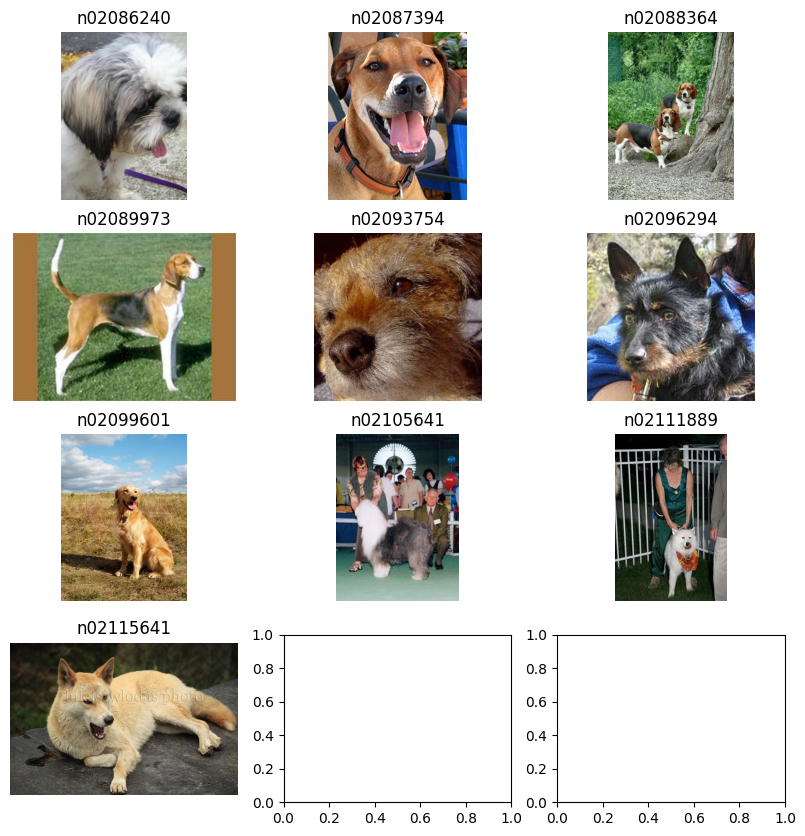

In [ ]:
# prompt: Show some image from each class

import glob
import matplotlib.pyplot as plt
from PIL import Image
import random

# Get a list of all the image files in the dataset.
images = glob.glob('/content/imagewoof2-320/val/*/*.JPEG')

# Create a figure with subplots to display the images.
fig, axs = plt.subplots(4, 3, figsize=(10, 10))

# Select a random image from each class and display it.
ids = sorted(set([image.split('/')[-2] for image in images]))
for i, cls in enumerate(ids):
  class_images = [image for image in images if image.split('/')[-2] == cls]
  random_image = random.choice(class_images)
  image = Image.open(random_image)
  axs[i // 3, i % 3].imshow(image)
  axs[i // 3, i % 3].set_title(cls)
  axs[i // 3, i % 3].axis('off')

# Show the plot.
plt.show()


In [ ]:
# Download ImageNet synset information and process it

!wget https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/d25516d26be4a8d3e0aeebe9275631754b8e2c73/imagenet_label_to_wordnet_synset.txt -P /content/imagewoof2-320

#!pip install pyyaml
import yaml

with open("/content/imagewoof2-320/imagenet_label_to_wordnet_synset.txt", 'r') as stream:
  data = yaml.safe_load(stream)

id_to_label = {}
id_to_cls = {}
for i in data:
    entry = data[i]
    id = entry['id'].split('-')[1] + entry['id'].split('-')[0]
    label = entry['label']
    id_to_label[id] = label
    id_to_cls[id] = i

for id in ids:
    print(id, id_to_label[id])


--2024-05-13 23:34:21--  https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/d25516d26be4a8d3e0aeebe9275631754b8e2c73/imagenet_label_to_wordnet_synset.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134345 (131K) [text/plain]
Saving to: ‘/content/imagewoof2-320/imagenet_label_to_wordnet_synset.txt.1’

imagenet_label_to_w 100%[===================>] 131.20K  --.-KB/s    in 0.01s   

2024-05-13 23:34:21 (8.58 MB/s) - ‘/content/imagewoof2-320/imagenet_label_to_wordnet_synset.txt.1’ saved [134345/134345]

n02086240 Shih-Tzu
n02087394 Rhodesian ridgeback
n02088364 beagle
n02089973 English foxhound
n02093754 Border terrier
n02096294 Australian terrier
n02099601 golden retriever
n02105641 Old English sheepdog, bobtail
n02111889 S

In [ ]:
# prompt: Use keras to load a pretrained convnext model

import keras
from keras.applications import ConvNeXtTiny
cn_model = ConvNeXtTiny(weights='imagenet')


In [ ]:
# Create a model that applies cn_model to the input, but takes the output
# of the previous to last layer and normalize it

notop_model = keras.Model(inputs=cn_model.inputs, outputs=cn_model.layers[-2].output)

x = notop_model.output
x = keras.layers.UnitNormalization()(x)
emb_model = keras.Model(inputs=notop_model.inputs, outputs=x)


In [ ]:
# prompt: Load an image and apply both cn_model and emb_model
from keras.applications.resnet50 import decode_predictions
import numpy as np
image = Image.open('/content/imagewoof2-320/val/n02086240/ILSVRC2012_val_00002701.JPEG')
image = image.resize((224, 224))
# image = np.array(image) / 255.0 # WARNING: This is not needed since ConvNext preprocess the input

cn_output = cn_model.predict(np.expand_dims(image, axis=0))
emb_output = emb_model.predict(np.expand_dims(image, axis=0))


print('Class prediction:', np.argmax(cn_output), decode_predictions(cn_output, top=5))
print('Embedding shape:', emb_output.shape)


1/1 [==============================] - 4s 4s/step
Class prediction: 155 [[('n02086240', 'Shih-Tzu', 0.8654877), ('n02098413', 'Lhasa', 0.0620104), ('n02097474', 'Tibetan_terrier', 0.004730581), ('n02086079', 'Pekinese', 0.0011891675), ('n02110627', 'affenpinscher', 0.00061337947)]]
Embedding shape: (1, 768)


In [ ]:
# Load the weights of the last layer of the pretrained model and normalize them

weights = cn_model.layers[-1].get_weights()[0].T
print(weights.shape)
# normalize weights array
weights = weights / np.linalg.norm(weights, axis=-1, keepdims=True)

(1000, 768)


In [ ]:
# Create a KNN classifier with the weights

from sklearn.neighbors import KNeighborsClassifier

y_labels = np.arange(1000)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(weights, y_labels)

# test it with the embedding of the previous image
distances, indices = knn_model.kneighbors(emb_output)
print(distances, indices)

[[0.89635156 1.074327   1.21322215 1.27994396 1.30141024]] [[155 204 200 154 252]]


In [ ]:
import tensorflow as tf

cls_numb = tf.constant(list(map(lambda id:id_to_cls[id], ids)))

test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/imagewoof2-320/val',
    labels='inferred',
    label_mode='int',
    batch_size=256,
    image_size=(224, 224))


Found 3929 files belonging to 10 classes.


In [ ]:
y_labels = []
y_preds = []
for batch in iter(test_ds):
    print('.')  # progress bar
    imgs, y = batch
    emb = emb_model(imgs)
    distances, indices = knn_model.kneighbors(emb)
    y_label = np.take(cls_numb, y)
    y_labels.extend(y_label)
    y_preds.extend(indices[:, 0])



.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_labels = np.array(y_labels)
y_preds = np.array(y_preds)

print(classification_report(y_labels, y_preds, labels=np.unique(y_labels)))
print(f'Accuracy: {accuracy_score(y_labels, y_preds):.2f}')

              precision    recall  f1-score   support

         155       1.00      0.90      0.95       409
         159       0.99      0.91      0.95       408
         162       0.97      0.91      0.94       418
         167       0.98      0.70      0.82       224
         182       0.99      0.95      0.97       401
         193       1.00      0.77      0.87       407
         207       0.99      0.93      0.96       401
         229       1.00      0.97      0.98       422
         258       1.00      0.97      0.99       429
         273       0.99      0.86      0.92       410

   micro avg       0.99      0.90      0.94      3929
   macro avg       0.99      0.89      0.93      3929
weighted avg       0.99      0.90      0.94      3929

Accuracy: 0.90
